In [6]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn 
import numpy as np
import torch

In [37]:
cpx_res = pd.read_csv('/home/teddy/local/TKG-DTI/output/ablation/tkge/COMPLEX2/test_metrics.csv')
gnn_res = pd.read_csv('/home/teddy/local/TKG-DTI/output/ablation/tkge/GNN/test_metrics.csv')
data = torch.load('/home/teddy/local/TKG-DTI/data/tkg/processed/FOLD_0/Data.pt', weights_only=False)

rel2int = {k:v[0] for k,v in data.edge_reltype.items()} 
int2rel = {v:'->'.join(k) for k,v in rel2int.items()}

cpx_res = cpx_res.assign(remove_relation = cpx_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))
gnn_res = gnn_res.assign(remove_relation = gnn_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))

cpx_res = cpx_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
gnn_res = gnn_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()

cpx_res = cpx_res.assign(model='COMPLEX2')
gnn_res = gnn_res.assign(model='GNN') 
res = pd.concat([cpx_res, gnn_res], axis=0)
res = res.sort_values(by='MRR', ascending=False)
                         
res.head()

,remove_relation,MRR,avg_AUC,Top1,Top3,model
13,drug->PC3_lincs_perturbation_fwd->gene,0.216976,0.979838,0.132716,0.237654,COMPLEX2
22,gene->ASC_lincs_perturbation_rev->drug,0.216605,0.978628,0.132716,0.216049,COMPLEX2
9,drug->HA1E_lincs_perturbation_fwd->gene,0.214296,0.974368,0.126543,0.234568,COMPLEX2
20,drug->predicted_weak_binding_fwd->gene,0.213724,0.975745,0.129630,0.206790,COMPLEX2
17,drug->associates_fwd->disease,0.212867,0.975600,0.129630,0.209877,COMPLEX2


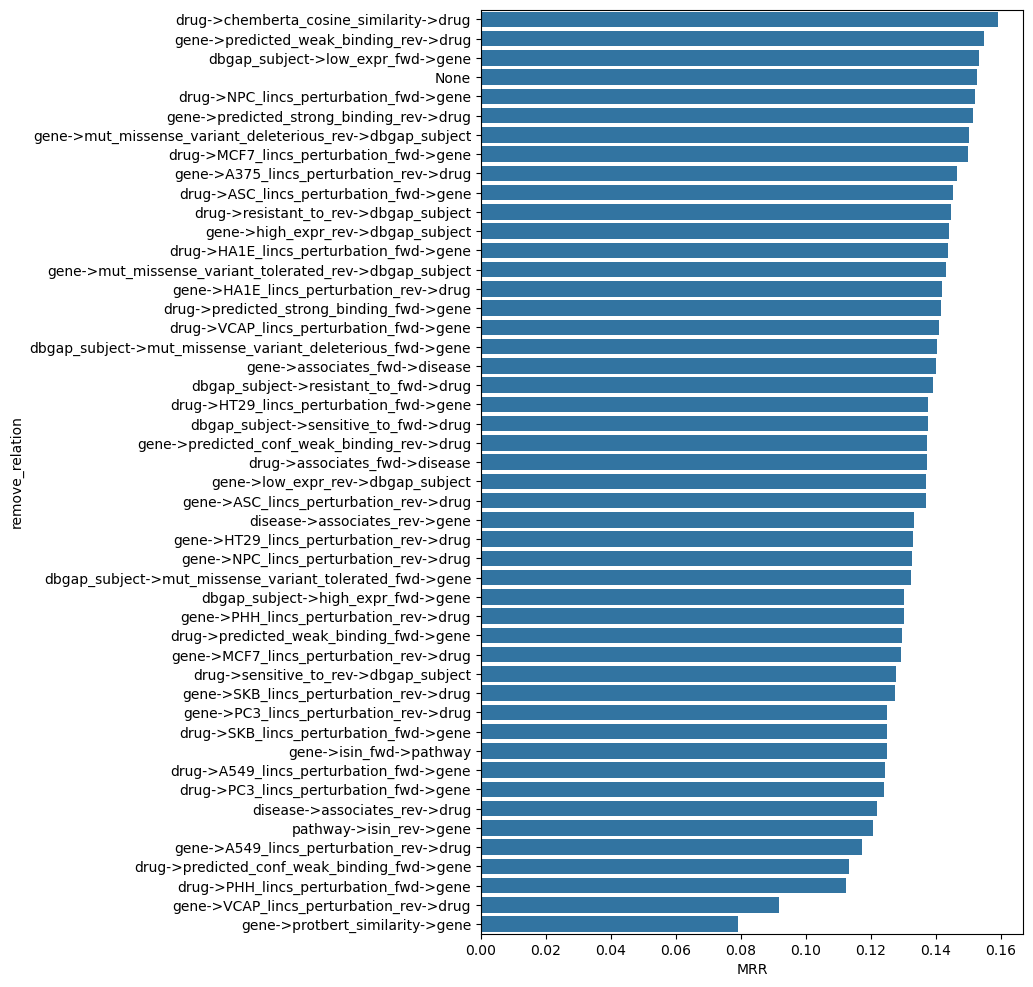

In [41]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='MRR', y='remove_relation', data=res[lambda x: x.model == 'GNN'].reset_index())
plt.show()

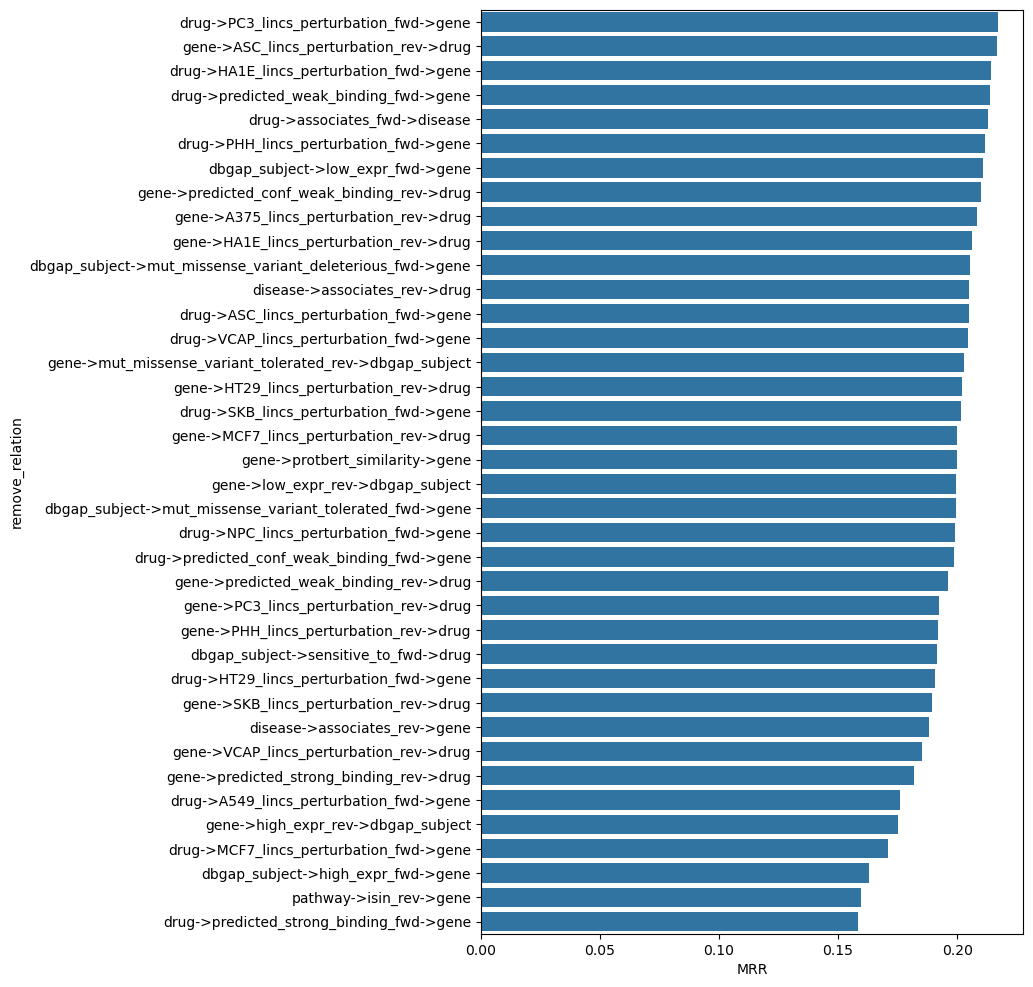

In [42]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='MRR', y='remove_relation', data=res[lambda x: x.model == 'COMPLEX2'])
plt.show()